In [1]:
!pip install picos
!pip install matplotlib
!pip install scipy

In [5]:
import picos

In [8]:
X = picos.SymmetricVariable("X", 4)
print(X >> 0)

X ≽ 0


In [13]:
from picos import RealVariable, BinaryVariable
t = RealVariable("t")
x = RealVariable("x", 4)
Y = RealVariable("Y", (2, 4))
Z = RealVariable("Z", (4, 2))
w = BinaryVariable("w") 

In [23]:
from picos import Constant
alpha = Constant('α', 23); print(alpha)

23.0


In [28]:
t**2 - x[1]*x[2] + 2*t - alpha

<Quadratic Expression: t² - x[1]·x[2] + 2·t - α>

In [29]:
P.options.solver = "cvxopt"

In [30]:
import picos as pic

In [59]:
P = pic.Problem()
t = pic.RealVariable('t')
P.set_objective('min', (t-5)**2 + 2)
print(P)

Quadratic Program
  minimize (t - 5)² + 2
  over
    1×1 real variable t


In [60]:
solution = P.solve()
solution.primals

{<1×1 Real Variable: t>: [4.999997568094726]}

In [61]:
max_t = P.add_constraint(t <= 5)

In [62]:
P.add_constraint(x << pic.Simplex())

<Unit Simplex Constraint: x ∈ {x ≥ 0 : ∑(x) ≤ 1}>

In [63]:
P.add_constraint( t == x.sum)

<1×1 Affine Constraint: t = ∑(x)>

In [64]:
P.remove_constraint(max_t)

In [65]:
print(P)

Quadratic Program
  minimize (t - 5)² + 2
  over
    1×1 real variable t
    4×1 real variable x
  subject to
    x ∈ {x ≥ 0 : ∑(x) ≤ 1}
    t = ∑(x)


**Projection onto a convex hull**

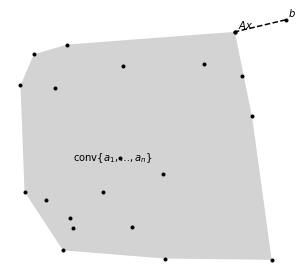

In [2]:
#!/usr/bin/env python3

import numpy as np
import picos as pc
from matplotlib import pyplot
from scipy import spatial

# Make the result reproducible.
# np.random.seed(12)

# Define the data.
n = 20
A = np.random.rand(2, n)
b = np.array([1, 1])

# Define the decision variable.
x = pc.RealVariable("x", n)

# Define and solve the problem.
P = pc.Problem()
P.minimize = abs(A*x - b)
P += pc.sum(x) == 1, x >= 0
P.solve(solver="cvxopt")

# Obtain the projection point.
p = (A*x).np

# Plot the results.
V = spatial.ConvexHull(A.T).vertices
figure = pyplot.figure(figsize=(8.7, 4))
figure.gca().set_aspect("equal")
pyplot.axis("off")
pyplot.fill(A.T[V, 0], A.T[V, 1], "lightgray")
pyplot.plot(A.T[:, 0], A.T[:, 1], "k.")
pyplot.plot(*zip(b, p), "k.--")
pyplot.annotate("$\mathrm{conv} \{a_1, \ldots, a_n\}$", [0.25, 0.5])
pyplot.annotate("$b$", b + 1/100)
pyplot.annotate("$Ax$", p + 1/100)
pyplot.tight_layout()
pyplot.show()

Let $M$ be a $(m\times n)-$Matrix, solve the problem $\min_{t,x}\{t\in\mathbb{R}:Mx\leq t, \langle 1,x\rangle=1\text{ and }x\geq 0\}$ from https://stackoverflow.com/questions/35675269/minimax-optimization-in-picos

In [24]:
import picos as pic
import cvxopt as cvx

n = 4
m = 3
M = cvx.normal(m, n) #generate a random matrix

P = pic.Problem()

x = pic.RealVariable("x", n)
t = pic.RealVariable("t")

P.add_constraint(M*x <= t)
P += pc.sum(x) == 1, x >= 0
P.set_objective("min", t)

In [25]:
print(P)

Linear Program
  minimize t
  over
    1×1 real variable t
    4×1 real variable x
  subject to
    [t] ≥ [3×4]·x
    ∑(x) = 1
    x ≥ 0


In [26]:
solutions = P.solve()

In [27]:
solutions.primals

{<1×1 Real Variable: t>: [-0.8600630349194727],
 <4×1 Real Variable: x>: [-9.617930678292048e-12,
  4.952529442946129e-12,
  1.0000000000119444,
  -7.279149234319895e-12]}

In [89]:
solutions.duals

{<3×1 Affine Constraint: [t] ≥ [3×4]·x>: <3x1 matrix, tc='d'>,
 <1×1 Affine Constraint: ∑(x) = 1>: <1x1 matrix, tc='d'>}

In [67]:
print(M)

[ 6.93e-01  1.51e-01  1.20e+00  5.03e-01]
[ 3.66e-01  5.54e-01  1.32e+00 -5.95e-01]
[-1.34e+00  2.51e-02 -2.42e-01 -4.84e-01]



Robust optimization:

$\min_{x\in\mathbb{R}^n}\max_{\theta\in\Theta}\|Ax-(b+\theta)\|$ subject to $\sum_{i=1}^nx_i=1$ and $x\geq0$, where $\Theta\doteq\{\theta:L\theta\leq 1\}$.

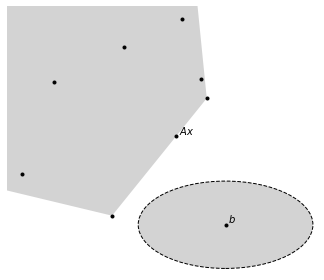

In [115]:
import numpy as np
import picos as pc
from matplotlib import pyplot
from matplotlib.patches import Ellipse
from scipy import spatial

# Make the result reproducible.
np.random.seed(12)

# Define the data.
n = 20
A = np.random.rand(2, n)
b = np.array([1, 0])

# Define an ellipsoidal uncertainty set Θ and a perturbation parameter θ.
# The perturbation is later added to the data, rendering it uncertain.
Theta = pc.uncertain.ConicPerturbationSet("θ", 2)
Theta.bound(  # Let ‖Lθ‖ ≤ 1.
  abs([[ 5,  0],
       [ 0, 10]] * Theta.element) <= 1
)
theta = Theta.compile()

# Define the decision variable.
x = pc.RealVariable("x", n)

# Define and solve the problem.
P = pc.Problem()
P.minimize = abs(A*x - (b + theta))
P += pc.sum(x) == 1, x >= 0
P.solve(solver="cvxopt")

# Obtain the projection point.
p = (A*x).np

# Plot the results.
V = spatial.ConvexHull(A.T).vertices
E = Ellipse(b, 0.4, 0.2, color="lightgray", ec="k", ls="--")
figure = pyplot.figure(figsize=(8.7, 4))
axis = figure.gca()
axis.add_artist(E)
axis.set_aspect("equal")
axis.set_xlim(0.5, 1.21)
axis.set_ylim(-0.11, 0.5)
pyplot.axis("off")
pyplot.fill(A.T[V, 0], A.T[V, 1], "lightgray")
pyplot.plot(A.T[:, 0], A.T[:, 1], "k.")
pyplot.plot(*zip(b, p), "k.")
pyplot.annotate("$\mathrm{conv} \{a_1, \ldots, a_n\}$", [0.25, 0.5])
pyplot.annotate("$b$", b + 1/200)
pyplot.annotate("$Ax$", p + 1/200)
pyplot.tight_layout()
pyplot.show()

In [103]:
Theta = pc.uncertain.ConicPerturbationSet("θ", 2)

In [105]:
print(Theta)

{θ : }


In [107]:
print(Theta.element)

θ


In [108]:
theta = Theta.compile()

In [110]:
print(theta)

θ
